#  📘3. LinUCB algorithm

---

##  목표

- UCB 방식은 exploration/exploitation trade-off를 잘 다룸
- 기존 UCB는 context 정보 활용 어려움
- $\Rightarrow$ Contextual Bandit + UCB 조합 필요

---

##  핵심 아이디어

- 보상을 feature의 선형 함수로 모델링
- 각 arm $a$마다 별도의 선형 회귀 모델 학습
- Ridge regression으로 파라미터 추정
- UCB를 통해 "예측 보상 + 불확실성"을 기반으로 arm 선택


### 📌 용어  


| 기호 | 의미 |
|----|----|
|$ r_{t,a}$ | 시간 t에 arm a의 실제 보상 |
|$ r_{t,a_t} $| 시간 t에 선택된 arm a_t의 보상 (실제 관측) |
| 기대 보상 | 주어진 feature에 따른 보상 기대값 |



---

###-  $r_{t,a}$의 의미

- $r_{t,a}$는 **사용자 $u_t$가 시간 $t$에 arm $a$를 선택했을 때의 실제 보상**입니다.
- 예시에서는:
  - 클릭 기반 뉴스 추천 상황이므로  
  - **$r_{t,a} = 1$** if clicked,  
  - **$r_{t,a} = 0$** if not clicked

---



- 실제 관측되는 보상은 오직 선택된 arm $a_t$에 대한 $r_{t,a_t}$뿐임.
- 선택하지 않은 arm들의 $r_{t,a}$는 **알 수 없음 (bandit 피드백의 특성)**


# 📘 Section 3.1: LinUCB with Disjoint Linear Models

---

## 🔹 모델 가정

각 arm $a$의 기대 보상은 다음과 같은 선형 함수로 표현됨:

$$
\mathbb{E}[r_{t,a} \mid x_{t,a}] = x_{t,a}^\top \theta^*_a
$$

- $x_{t,a} \in \mathbb{R}^d$: 사용자와 arm의 feature vector
- $\theta^*_a$: arm $a$의 (미지의) 파라미터
- 이 모델은 *disjoint* 하다. 파라미터들이 서로 다른 arm끼리 공유하지 않음.

---

## 🔹 Ridge Regression 기반 파라미터 추정

실험 $t$시점에서, $D_a$를 $m$x $d$ 차원의 설계 행렬(design matrix)라고 할때, 이 행렬의 각 행은 기사 $a$에 대해 이전에 관측된 $m$개의 컨텍스트 입력에 해당한다.

( $D_a$ , $c_a$) 학습 데이터를 사용해 릿지 회귀(ridge regression)를 적용하면 계수의 추정값을 구할 수 있다: (e.g., click/no-click feedback).


$$
\hat{\theta}_a = (D_a^\top D_a + I_d)^{-1} D_a^\top c_a \
$$

-> $I_d$는$d \times d$  단위 행렬

---

## 🔹 신뢰구간 부등식

$c_a$의 성분들이 $D_a$의 행이 주어졌을 때 조건부로 독립이라면, $1 - \delta$ 이상의 확률로 다음이 성립함을 [27]에서 보였다:
$$
\left| x_{t,a}^\top \hat{\theta}_a - \mathbb{E}[r_{t,a} \mid x_{t,a}] \right| \leq \alpha \sqrt{x_{t,a}^\top (D_a^\top D_a + I_d)^{-1} x_{t,a}}
$$

$\delta > 0$,   $x_{t,a} \in \mathbb{R}^d$ , $\alpha = 1 + \sqrt{\ln(2/\delta)/2}$  

$\delta$는 오류 허용값이며, α는 신뢰 구간의 크기를 조정하는 상수.

---

## 🔹 Arm 선택 공식 (UCB)

위의 신뢰구간 부등식에 따르면 이를 기반으로 UCB 기반 선택 전략을 만들 수 있다. 즉, 각 시점 t마다 다음을 선택한다:

$$
a_t = \arg\max_{a \in A_t} \left( x_{t,a}^\top \hat{\theta}_a + \alpha \sqrt{x_{t,a}^\top A_a^{-1} x_{t,a}} \right)
$$

이때 , $A_a = D_a^\top D_a + I_d$. 라고 정의한다

---

## 🔹 Bayesian 해석 및 정보 이론적 해석

릿지 회귀는 베이지안 관점에서 계수의 **점 추정(point estimate)** 으로 해석될 수 있다.

이때 파라미터 벡터 $\theta_a$의 사후 분포 $p(\theta_a)$는 평균이 $\hat{\theta}_a$이고 공분산이 $A_a^{-1}$인 가우시안 분포가 된다.
$$p(\theta_a)\sim \mathcal{N}(\hat{\theta}_a, A_a^{-1})$$
기대 보상 $x_{t,a}^\top \theta^*_a$ 의 예측 분산은:

$$
\mathrm{Var}(x_{t,a}^\top \theta^*_a) = x_{t,a}^\top A_a^{-1} x_{t,a}
$$

표준편차는:

$$
\sigma = \sqrt{x_{t,a}^\top A_a^{-1} x_{t,a}}
$$

더 나아가, 이론[19]에 따르면  $p(\theta_a)$의 미분 엔트로피는 아래의 식으로 정의된다:

$$
H(p(\theta_a)) = -\frac{1}{2} \ln\left( (2\pi)^d \cdot \det A_a \right)$$

새로운 데이터 $x_{t,a}$를 포함하여  $p(\theta_a)$를 갱신:


$$H_{\text{updated}}(p(\theta_a)) = -\frac{1}{2} \ln\left( (2\pi)^d \cdot \det(A_a + x_{t,a} x_{t,a}^\top) \right)$$

엔트로피 감소량 (정보 이득):
$$
\Delta H = \frac{1}{2} \ln\left( 1 + x_{t,a}^\top A_a^{-1} x_{t,a} \right)
$$
이 값은 새로운 문맥 $\mathbf{x}_{t,a}$ 모델 개선에 얼마나 기여했는지를 평가하는 데 자주 사용된다.

---

## 🔹 Algorithm 1: LinUCB with disjoint linear models

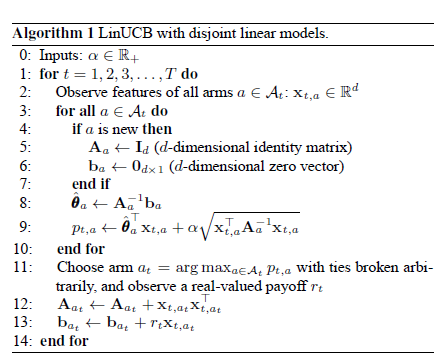

## 📘 Algorithm 1: LinUCB with Disjoint Linear Models

(각 팔 별로 독립된 선형 모델을 사용)

---

### `0: Inputs: α ∈ ℝ⁺`
입력값: $\alpha > 0$

→ 신뢰 구간의 크기를 조절하는 하이퍼파라미터 (탐색 vs. 이용의 균형 조절)

---

### `1: for t = 1, 2, 3, ..., T do`
시점 $t=1$부터 $T$까지 매 시점에 대해 다음 절차를 반복한다.

---

### `2: Observe features of all arms a ∈ Aₜ: xₜ,ₐ ∈ ℝᵈ`
현재 시점 $t$에서 선택 가능한 팔 $a \in A_t$ 각각에 대해 ${x}_{t,a} \in \mathbb{R}^d$특징 벡터 를 관측한다.

> 문맥 벡터로, 사용자 + 아이템 정보를 결합한 형태
>

---

### `3: for all a ∈ Aₜ do`
팔 집합 $A_t$에 속한 모든 arm $a$에 대해 다음 단계를 실행한다.

---

### `4: if a is new then`
만약 arm $a$가 처음 등장한 팔이라면 (이전까지 관측/학습된 적이 없다면),

---

### `5: Aₐ ← I_d (d-dimensional identity matrix)`
행렬 $A_a$를 $d \times d$ 단위 행렬로 초기화한다.

> Ridge 회귀에서 정규화 항으로 사용되는 초기 값
>

---

### `6: bₐ ← 0_{d×1} (d-dimensional zero vector)`
벡터 $b_a$를 0 벡터로 초기화한다.

→ 보상 정보를 누적하는 데 사용됨

---

### `7: end if`
초기화 종료

---

### `8: θ̂ₐ ← Aₐ⁻¹ bₐ`
팔 $a$의 파라미터 $\hat{\boldsymbol{\theta}}_a$를 아래와 같이 계산한다. $\hat{\boldsymbol{\theta}}_a = A_a^{-1} b_a$

> Ridge 회귀의 닫힌 형태
>

---

### `9: pₜ,ₐ ← θ̂ₐᵀ xₜ,ₐ + α √(xₜ,ₐᵀ Aₐ⁻¹ xₜ,ₐ)`
arm $a$  의 Upper Confidence Bound (UCB) 값을 계산한다:

 $p_{t,a} = \hat{\boldsymbol{\theta}}_a^\top \mathbf{x}_{t,a} + \alpha \sqrt{ \mathbf{x}_{t,a}^\top A_a^{-1} \mathbf{x}_{t,a} }$

→ 예측된 보상 + 불확실성 항 (탐색 보너스)

---

### `10: end for`

모든 팔에 대해 UCB 계산을 마침

---

### `11: Choose arm aₜ = argmaxₐ∈Aₜ pₜ,ₐ with ties broken arbitrarily, and observe a real-valued payoff rₜ`
가장 큰 UCB 값을 가진 arm $a_t$를 선택하고, 실제 보상 를 관측한다.

(동률일 경우 무작위 선택)

---

### `12: Aₐₜ ← Aₐₜ + xₜ,ₐₜ xₜ,ₐₜᵀ`
선택된 arm $a_t$에 대해, 행렬 $A_{a_t}$를 업데이트한다.

→ 새로운 문맥 벡터 정보를 반영하여 피처 간 상관을 갱신

---
### `13: bₐₜ ← bₐₜ + rₜ xₜ,ₐₜ`
선택된 arm $a_t$에 대해, 벡터 $b_{a_t}$를 업데이트한다.

→ 새로 받은 보상 $r_t$를 문맥 벡터에 곱해 누적

---
### `14: end for`
시점 $t$의 루프 종료 → 다음 시점으로 넘어감